In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [0]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [57]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [59]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [60]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

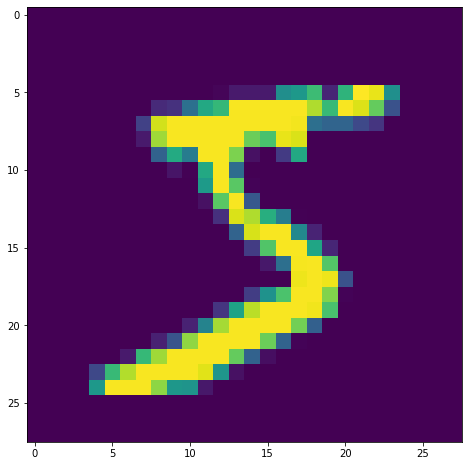

tensor(5)


In [61]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [0]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [120]:
torch.cuda.is_available()

True

In [121]:
!nvidia-smi

Sat Dec 14 16:32:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   8437MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [0]:
batch_size = 1000

train_accuracy_history = []
train_loss_history = []

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
    order = np.random.permutation(len(X_train))

    arr_acc = []
    arr_loss = []
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index: start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = mnist_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        arr_loss.append(loss_value)
        loss_value.backward()
        train_accuracy = (preds.argmax(dim=1)==y_batch).float().mean()
        arr_acc.append(train_accuracy)

        optimizer.step()

    train_accuracy_history.append(torch.mean(torch.Tensor(arr_acc)))
    train_loss_history.append(torch.mean(torch.Tensor(arr_loss)))
    
    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))

    accuracy = (test_preds.argmax(dim=1)==y_test).float().mean()
    test_accuracy_history.append(accuracy)
    # print(accuracy)

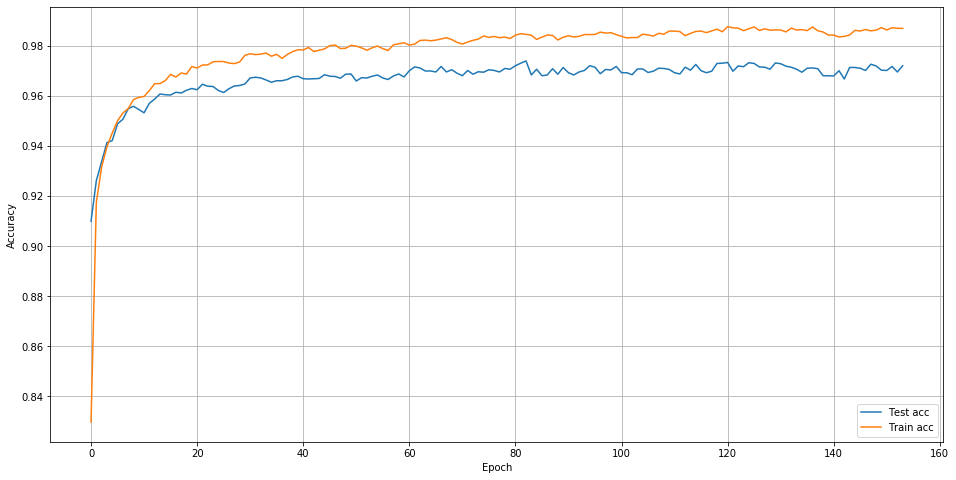

In [111]:
plt.plot(test_accuracy_history, label='Test acc')
plt.plot(train_accuracy_history, label='Train acc')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show();

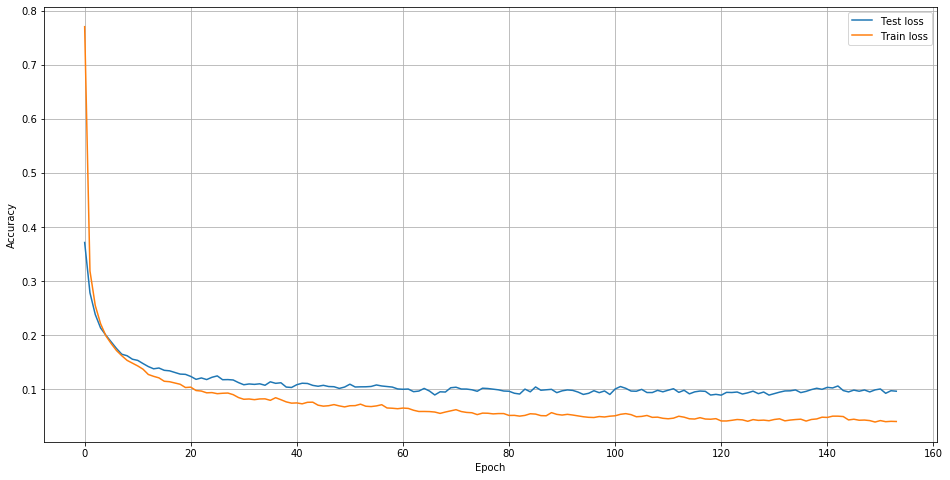

In [112]:
plt.plot(test_loss_history, label='Test loss')
plt.plot(train_loss_history, label='Train loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show();

In [134]:
%%time
from torch.optim import Adadelta, Adam, RMSprop, SGD

arr_optim = [Adadelta, Adam, RMSprop, SGD]

test_accuracy_history_adadelta = []
test_accuracy_history_adam = []
test_accuracy_history_rmsprop = []
test_accuracy_history_sgd = []

for optim in arr_optim[::-1]:
    print(optim)
    mnist_net = MNISTNet(100)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mnist_net = mnist_net.to(device)
    
    loss = torch.nn.CrossEntropyLoss()
    optimizer = optim(mnist_net.parameters(), lr=1.0e-3)
    
    batch_size = 1000

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(150):
        order = np.random.permutation(len(X_train))

        arr_acc = []
        arr_loss = []
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index: start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = mnist_net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            arr_loss.append(loss_value)
            loss_value.backward()
            train_accuracy = (preds.argmax(dim=1)==y_batch).float().mean()
            arr_acc.append(train_accuracy)

            optimizer.step()

        test_preds = mnist_net.forward(X_test)
        accuracy = (test_preds.argmax(dim=1)==y_test).float().mean()
        if optim == torch.optim.Adadelta:
            test_accuracy_history_adadelta.append(accuracy)
        elif optim == torch.optim.Adam:
            test_accuracy_history_adam.append(accuracy)
        elif optim == torch.optim.RMSprop:
            test_accuracy_history_rmsprop.append(accuracy)
        else:
            test_accuracy_history_sgd.append(accuracy)

<class 'torch.optim.sgd.SGD'>
<class 'torch.optim.rmsprop.RMSprop'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.adadelta.Adadelta'>
CPU times: user 1min 34s, sys: 3.49 s, total: 1min 38s
Wall time: 1min 38s


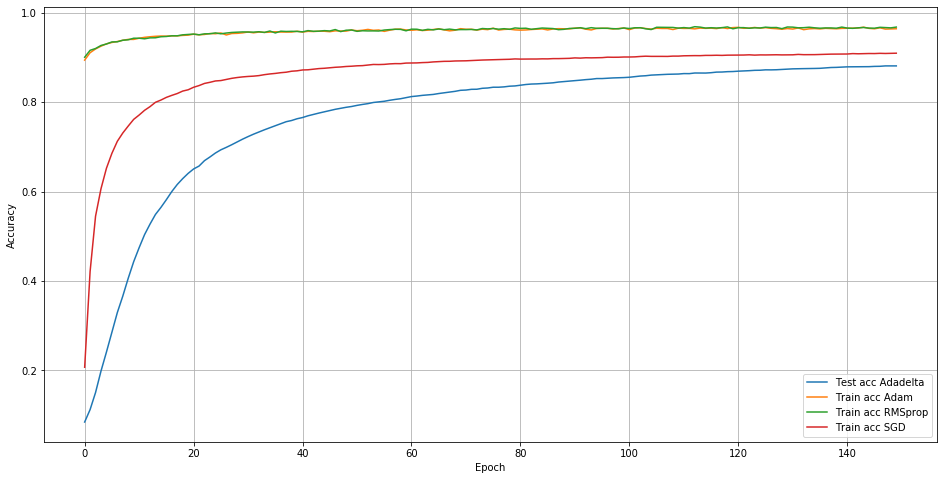

In [135]:
plt.plot(test_accuracy_history_adadelta, label='Test acc Adadelta')
plt.plot(test_accuracy_history_adam, label='Train acc Adam')
plt.plot(test_accuracy_history_rmsprop, label='Train acc RMSprop')
plt.plot(test_accuracy_history_sgd, label='Train acc SGD')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show();

In [0]:
x = torch.zeros([6000, 28, 28], dtype=torch.int32)

In [36]:
x.reshape(-1, 1, 1).shape

torch.Size([4704000, 1, 1])

In [37]:
x.reshape(len(x[1]), len(x), len(x[2])).shape

torch.Size([28, 6000, 28])

In [38]:
x.reshape(-1, 6000).shape

torch.Size([784, 6000])

In [39]:
x.shape

torch.Size([6000, 28, 28])

In [40]:
x.reshape(-1, 14, 32, 7).shape

torch.Size([1500, 14, 32, 7])

In [41]:
x.reshape(-1, 9).shape

RuntimeError: ignored

In [42]:
x.reshape(-1).shape

torch.Size([4704000])